# Benchmark

In [1]:
# imports

import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import numpy as np
import gc

import catboost ## thanks to yandex ! :) 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# info about itertools.product: 
# https://pythonworld.ru/moduli/modul-itertools.html
# https://docs.python.org/2/library/itertools.html
from itertools import product


In [2]:
# downcast types to save memory

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Download data from https://www.kaggle.com/c/competitive-data-science-final-project/data and save *.csv to 'data' folder

File descriptions

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

In [3]:
sales = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data//items.csv')
item_cats = pd.read_csv('data/item_categories.csv')
test = pd.read_csv('data/test.csv')

Data fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* ***item_cnt_day - number of products sold. You are predicting a monthly amount of this measure***
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [4]:
print(sales.shape)
sales.head(2)

# 3m rows! 

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [5]:
print(shops.shape)
shops.head(2)

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [6]:
print(items.shape)
items.head(2)

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [7]:
print(item_cats.shape)
item_cats.head(2)

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [8]:
test["date_block_num"] = sales.date_block_num.max() + 1
sales = pd.concat([sales, test])

In [9]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.head(2)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0


In [10]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
all_data.head(2)

,shop_id,item_id,date_block_num,target,target_shop
0,59,22154,0,1.0,2017.0
1,59,2552,0,0.0,2017.0


In [11]:
# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

all_data.head(2)

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0


In [12]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [13]:
# !! Don't use old data from year 2013 !! 
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

all_data.head(2)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38


In [14]:
# now separate train and test
test = pd.merge(test, all_data[all_data["date_block_num"] == 34], on=["shop_id", "item_id", "date_block_num"])
train = all_data[all_data["date_block_num"] < 34]

In [15]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = train['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


# Some data analysis

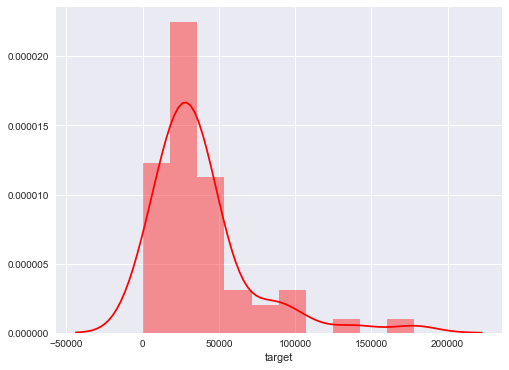

In [16]:
plt.figure(figsize=(8, 6))
sns.distplot(train.groupby("shop_id").target.sum(), bins=10, kde=True, color="r")

# You can try to make this distribution normal

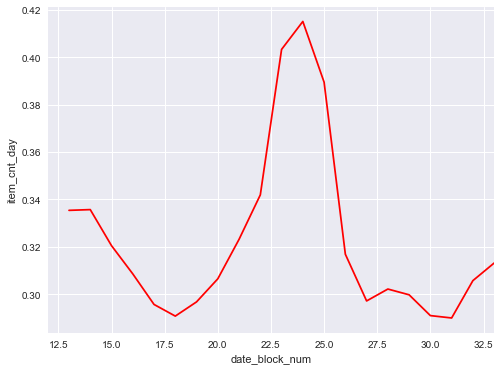

In [17]:
ax = pd.rolling_mean(train.groupby("date_block_num").target.mean(), 
                window=3, min_periods=2).plot(figsize=(8,6), c="r")

ax.set_ylabel("item_cnt_month")

# Maybe it worths to check previous months 

# Validation

In [19]:
# validate our model on last month of train (October, 2015)

dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = train.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  train.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = train.loc[dates <  last_block, 'target'].values
y_test =  train.loc[dates == last_block, 'target'].values

In [24]:
boost = catboost.CatBoostRegressor(iterations=100)
boost.fit(X_train.values, y_train)
preds = boost.predict(X_test)
print("catboost score = {}".format(mean_squared_error(y_test, preds)))

catboost score = 20.9240106963


In [28]:
test = test[X_train.columns]
preds = boost.predict(test)
ss = pd.read_csv("data/sample_submission.csv")
ss.item_cnt_month = preds
ss.to_csv("catboost_first_submit.csv", index=False)